# Collision Avoidance Task

### Overview
This notebook demonstrates multi-agent planning with and without Theory of Mind (ToM) in a cooperative collision avoidance task using sophisticated active inference. These experiments are published in: ["Theory of Mind Using Active Inference: A Framework for Multi-Agent Cooperation"](https://arxiv.org/abs/2508.00401). Note that in the paper, locations are numbered 1–9, but in the codebase, they start at 0 instead of 1 (i.e., 0–8).

### Task Description
The collision avoidance task takes place in a 3×3 grid environment. Agents begin in opposing corners of the grid and must traverse to the opposite corner without occupying the same location as the other agent (i.e., they must avoid colliding with one another).

### Experiments
All agents use sophisticated inference planning with the `another_works_for_tom` branch of pymdp.

1. **Two non-ToM Agents** - Two agents planning without Theory of Mind capabilities. Uses our custom rollout function with planning tree recycling that supports multiple agents in a shared environment.

2. **One ToM Agent with One non-ToM Agent** - One agent with Theory of Mind capabilities cooperating with one agent without Theory of Mind capabilities. Uses our custom rollout function which accommodates both non-ToM and ToM planning strategies and multiple agents in one shared environment. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import equinox as eqx

import matplotlib.pyplot as plt

from tom.envs import CollisionAvoidanceEnv
from tom.models import CollisionAvoidanceModel, CollisionAvoidanceAgent
from tom.planning.visualize import visualize_plan_tree, visualize_env

from tom.planning.si import si_policy_search as si_policy_search_nontom
from tom.planning.si_tom import si_policy_search_tom, ToMify

from tom.planning.rollout import rollout as rollout_nontom
from tom.planning.rollout_tom import rollout as rollout_tom

# Two non-ToM Agents

Initialize the environment

In [3]:
grid_size = 3
num_agents = 2
initial_positions = jnp.array([0, 8])

env = CollisionAvoidanceEnv(num_agents, grid_size, initial_positions) 

/var/folders/m1/2n727yx90pn_hq1lr6drrkxc0000gn/T/ipykernel_46958/3168005686.py:5: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  env = CollisionAvoidanceEnv(num_agents, grid_size, initial_positions)


Initialize the agents

In [4]:
gamma = 1.0

model = CollisionAvoidanceModel(batch_size=num_agents, initial_positions=initial_positions)
agents = CollisionAvoidanceAgent(model, gamma=gamma, batch_size=num_agents)

Set up the non-ToM planning algorithm

In [5]:
horizon=3
max_nodes = 5000
max_branching = 10
policy_prune_threshold = 1 / 8
observation_prune_threshold = 1 / 8
entropy_stop_threshold = 0.5
efe_stop_threshold = 5
kl_threshold=1e-2
prune_penalty = 512

# set up the policy search function
tree_search_nontom = si_policy_search_nontom(
        horizon=horizon,
        max_nodes=max_nodes,
        max_branching=max_branching,
        policy_prune_threshold=policy_prune_threshold,
        observation_prune_threshold=observation_prune_threshold,
        entropy_stop_threshold=entropy_stop_threshold,
        efe_stop_threshold=efe_stop_threshold,
        kl_threshold=kl_threshold,
        prune_penalty=prune_penalty,
        gamma=gamma
    )

Running the agent using the sophisticated inference planning without theory of mind capabilities (`si_policy_search_nontom`) and the custom rollout function which allows multiple agents to interact within the same environment.

In [6]:
T = 3
key = jr.PRNGKey(1)
last, info_nontom, env = rollout_nontom(agents, env, T, key, policy_search=tree_search_nontom)

/Users/riddhi/Documents/Projects/meltingpot_rjp/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/meltingpot_rjp/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [7]:
visualize_env(info_nontom, model=model, save_as_gif=False, gif_filename="collisionavoidance_nontom.gif")

Plan tree of the red non-ToM agent

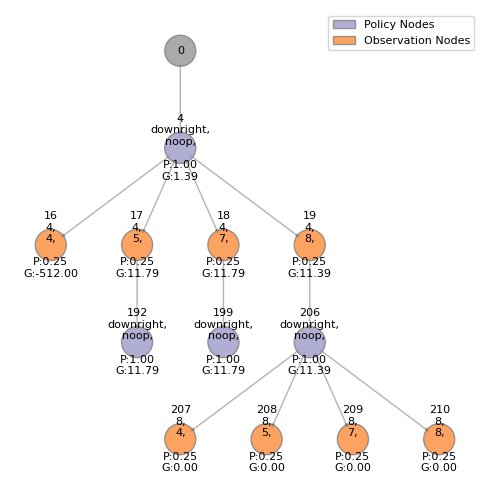

In [8]:
visualize_plan_tree(info_nontom, time_idx=0, agent_idx=0, model=model, depth=4, fig_size=(5,5))

Plan tree of the purple non-ToM agent

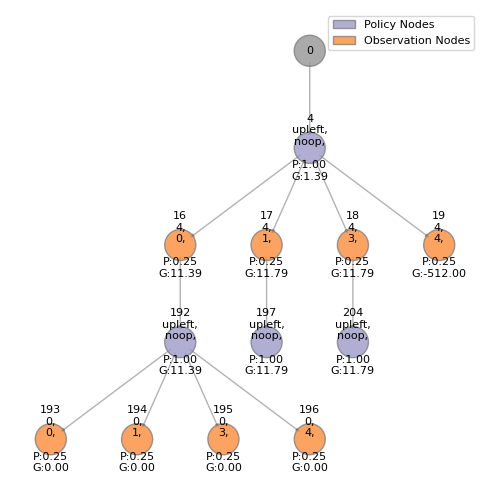

In [9]:
visualize_plan_tree(info_nontom, time_idx=0, agent_idx=1, model=model, depth=4, fig_size=(5,5))

# One ToM Agent with One non-ToM Agent

Initialize the agents

In [10]:
focal_model = CollisionAvoidanceModel(batch_size=1, initial_positions=initial_positions[0][None, ...])
agent0 = CollisionAvoidanceAgent(focal_model, gamma=gamma, batch_size=1)
focal_agent = ToMify(agent0,
                     self_states=[0],
                     world_states=[],
                     # observation mappings is of size (focal_batch, num_agents, num_modalities)
                     # for each obs modality of the agent, we set which actual received obs modality should be used
                     # e.g. you'll get 2 observation modalities,
                     # here we assume agents observe both their own and the other's location
                     observation_mappings=jnp.array([[[0, 1],[1, 0]]]),
                     # state mappings is of size (focal_batch, num_other_agents, num_state_factors)
                     # and its meaning is, for each other agent, we specify whether a focal agent's state factor maps to one of this other agent's state factors
                     # -1 meaning that none of the other agent's state factors map to this one
                     # so here it means that for the other agent, the 0th focal state factor has no mapping (-1), but the 1st focal state factor maps to the 0th of the other
                     state_mappings=[[[-1, 0]]])

# we have to set the preferences for the focal agent's beliefs about the other agents correctly here otherwise it just copies its own model (and its own preferences)
focal_agent = eqx.tree_at(lambda x: x.agent_models.C, focal_agent, [c[None, ...] for c in agents.C])

other_model = CollisionAvoidanceModel(batch_size=1, initial_positions=initial_positions[1][None, ...])
other_agents = CollisionAvoidanceAgent(other_model, gamma=gamma, batch_size=1)

Running the agent using the sophisticated inference planning with theory of mind capabilities (`si_policy_search_tom`) and the custom rollout function which allows non-ToM and ToM agents to interact within the same environment.

In [11]:
tree_search_tom = si_policy_search_tom(
            horizon=horizon,
            max_nodes=max_nodes,
            max_branching=max_branching,
            policy_prune_threshold=policy_prune_threshold,
            observation_prune_threshold=observation_prune_threshold,
            entropy_stop_threshold=entropy_stop_threshold,
            efe_stop_threshold=efe_stop_threshold,
            kl_threshold=kl_threshold,
            prune_penalty=prune_penalty,
            gamma=gamma,
        )

In [12]:
key = jr.PRNGKey(1)
T=3
last, info_tom, env = rollout_tom(focal_agent,
            other_agents,
            env,
            T,
            key,
            other_agent_policy_search=tree_search_nontom,
            focal_agent_tom_policy_search=tree_search_tom,
)

/Users/riddhi/Documents/Projects/meltingpot_rjp/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/meltingpot_rjp/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [13]:
visualize_env(info_tom, model=model, save_as_gif=False, gif_filename="collisionavoidance_tom.gif")

Plan tree of the red ToM agent

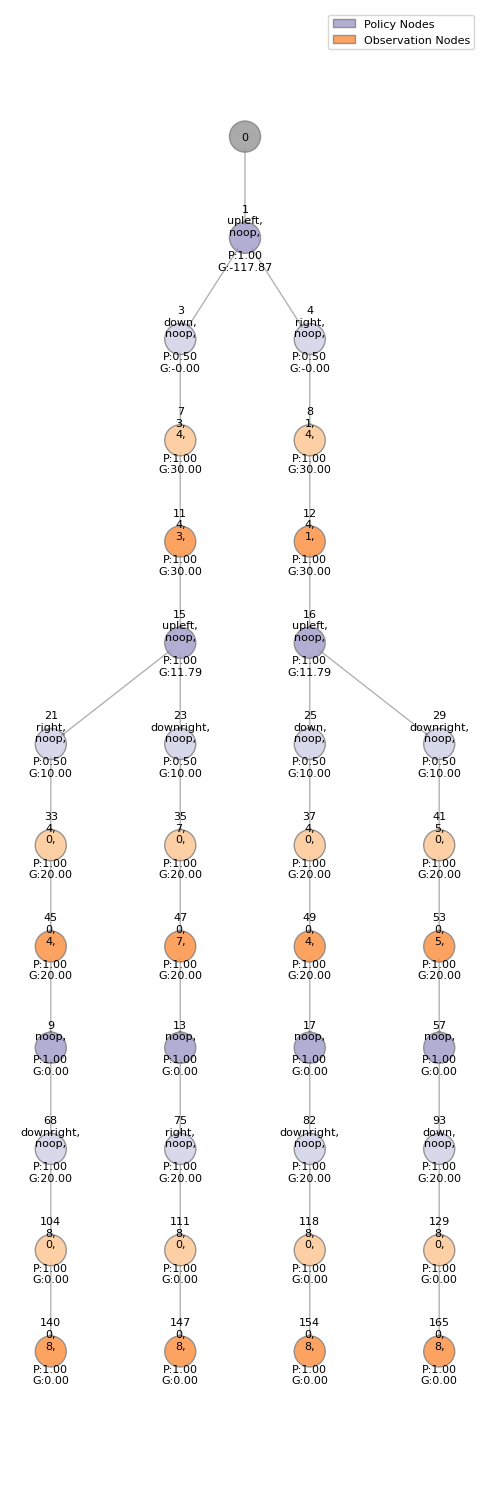

In [19]:
visualize_plan_tree(info_tom, time_idx=0, agent_idx=0, model=model, depth=12, root_idx=0, fig_size=(5,15))

Plan tree of the purple non-ToM agent

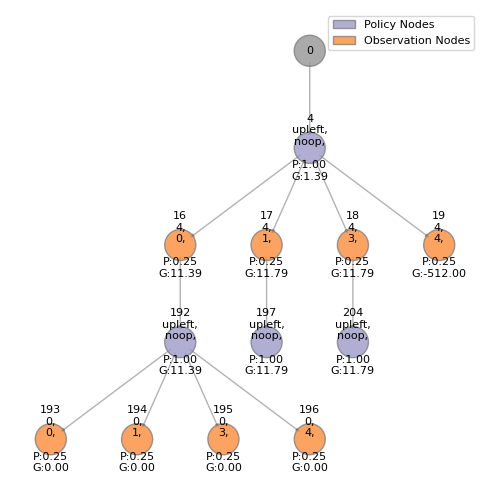

In [15]:
visualize_plan_tree(info_tom, time_idx=0, agent_idx=1, plotting_other_intom=True, model=model, root_idx=0, fig_size=(5,5))